In [1]:
# from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

# # Set up the dataset.
# delta_timestamps = {
#     # Load the previous image and state at -0.1 seconds before current frame,
#     # then load current image and state corresponding to 0.0 second.
#     "observation.image": [0.0],
#     "observation.state": [0.0],
#     # Load the previous action (-0.1), the next action to be executed (0.0),
#     # and 14 future actions with a 0.1 seconds spacing. All these actions will be
#     # used to supervise the policy.
#     "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3],
# }

# dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)


In [2]:

# # example.py
# import gymnasium as gym
# import gym_pusht

# env = gym.make("gym_pusht/PushT-v0", obs_type="pixels_agent_pos", render_mode="human")
# observation, info = env.reset()
# # transforms = transforms.Compose([
# #     transforms.Resize((96, 96)),  # Ensure input is 96x96
# #     transforms.ToTensor(),
# #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# # ])

# for _ in range(1000):
#     action = env.action_space.sample()
#     print(action)
#     observation, reward, terminated, truncated, info = env.step(action)
#     image = env.render()

#     if terminated or truncated:
#         observation, info = env.reset()

# # env.close()

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import theseus as th
import copy
from cvae_utilities import *
import copy
import os
import wandb
from torch.cuda.amp import autocast, GradScaler


class CVAEWithTrajectoryOptimization(nn.Module):
    def __init__(self, cfg):
        super(CVAEWithTrajectoryOptimization, self).__init__()
        state_dim = cfg.state_dim
        action_dim = cfg.action_dim * cfg.horizon
        latent_dim_state = cfg.latent_dim_state 
        latent_dim_action = cfg.latent_dim_action * cfg.horizon
        posterior_dim = cfg.posterior_dim
        device = cfg.device
        self.state_encoder = StateEncoder(state_dim, latent_dim_state).to(device)
        self.action_encoder = ActionEncoder(action_dim, latent_dim_action).to(device)
        self.fusing_encoder = FusingEncoder(latent_dim_state, latent_dim_action, posterior_dim).to(device)
        self.dynamics_function = DynamicsFunction(latent_dim_state, latent_dim_action, posterior_dim).to(device)
        self.action_decoder = ActionDecoder(posterior_dim, latent_dim_state, action_dim).to(device)
        self.reward_decoder = RewardDecoder(latent_dim_state, latent_dim_action, posterior_dim).to(device)
        self.posterior_dim = posterior_dim
        self.device = device
        self.cfg = cfg

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, zs, za):
        """
        Perform a forward pass through the model.
        Args:
            obs: Observation (raw img input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            action: Action (latent action input), shape [batch_size, horizon * action_dim].
        Returns:
            reconstructed_action: Reconstructed action, shape [batch_size, horizon, action_dim].
            z_mu: Mean of the posterior Gaussian, shape [batch_size, posterior_dim].
            z_logvar: Log-variance of the posterior Gaussian, shape [batch_size, posterior_dim].
            _zs: Predicted next latent state, shape [batch_size, state_dim].
        """
    
        # Encode state and action
        # zs = self.state_encoder(obs, state)
        # za = self.action_encoder(action)

        # Fuse state and action for posterior Gaussian
        z_mu, z_logvar = self.fusing_encoder(zs, za)

        # Sample from posterior Gaussian
        fused_latent = self.reparameterize(z_mu, z_logvar)

        reconstructed_action = self.action_decoder(fused_latent, zs)

        # Predict next latent state
        _zs = self.dynamics_function(zs, self.action_encoder(reconstructed_action), fused_latent)#TODO: check if this is correct

        return reconstructed_action, z_mu, z_logvar, _zs
    
    def generate_action(self, zs, zp):
        """
        Generate an action based on the given observation.
        Args:
            obs: Observation (raw state input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            z: Latent variable z, shape [batch_size, posterior_dim].
        Returns:
            action: Generated action, shape [batch_size, action_dim].
        """

        # Decode action from latent state and z
        reconstructed_action = self.action_decoder(zp, zs)  # Reconstruct action

        _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action), zp)

        return reconstructed_action, _zs, _zp

    def save_pretrained(self, save_directory):
        """Save model weights and config to directory"""
        os.makedirs(save_directory, exist_ok=True)
        
        # Save model state dict
        model_path = os.path.join(save_directory, "model.pt")
        torch.save({
            'state_encoder': self.state_encoder.state_dict(),
            'action_encoder': self.action_encoder.state_dict(),
            'fusing_encoder': self.fusing_encoder.state_dict(),
            'dynamics_function': self.dynamics_function.state_dict(),
            'action_decoder': self.action_decoder.state_dict(),
            'reward_decoder': self.reward_decoder.state_dict(),
            'cfg': self.cfg
        }, model_path)

    def load_pretrained(self, load_directory):
        """Load model weights and config from directory"""
        model_path = os.path.join(load_directory, "model.pt")
        if not os.path.exists(model_path):
            raise ValueError(f"Model file not found at {model_path}")
            
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Load model weights
        self.state_encoder.load_state_dict(checkpoint['state_encoder'])
        self.action_encoder.load_state_dict(checkpoint['action_encoder'])
        self.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
        self.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
        self.action_decoder.load_state_dict(checkpoint['action_decoder'])
        self.reward_decoder.load_state_dict(checkpoint['reward_decoder'])
        
        # Load config
        self.cfg = checkpoint['cfg']

    def plan_with_theseus_update(self, obs, state, action, horizon, gamma, cfg, eval_mode=False):#TODO: add constrain on the range of action
        """
        Perform trajectory optimization using Theseus.
        Args:
            obs: Observation (raw state input).
            horizon: Planning horizon.
            gamma: Discount factor.
            model: The CVAE model containing dynamics and state encoders.
            cfg: Configuration object (for damping, step size, etc.).
            eval_mode: Whether to evaluate without gradients.
        """
        # Prepare initial observation
        batch_size = obs.shape[0]
        obs = torch.tensor(obs[:,0,...], dtype=torch.float32, device=self.device) # [bs, 3, 96, 96]
        state = torch.tensor(state[:,0,...], dtype=torch.float32, device=self.device)# [bs, 2]
        action = torch.tensor(action, dtype=torch.float32, device=self.device) # [bs, horizon * 2 * 2]
        horizon = int(min(horizon, cfg.horizon))  # Clip planning horizon

        # Initialize latent state and actions
          # Latent state
        # actions = torch.zeros(batch_size, horizon, cfg.action_dim, device=self.device, requires_grad=True)  # Initial actions

        # Precompute initial actions using policy (if available)
        pi_actions = torch.empty(batch_size, horizon, cfg.action_dim * horizon, device=self.device)
        expert_actions = torch.empty(batch_size, horizon, cfg.action_dim * horizon, device=self.device)
        z_mus = []
        z_logvars = []

        zs = self.state_encoder(obs, state) # 【bs, 50]
        zs0 = zs.clone()
        # pz = torch.randn(batch_size, model.posterior_dim, device=self.device)
        # pz0 = pz.clone()
        # with torch.no_grad():
        # consistance_loss = 0 #TODO: calculate consistance loss by mse(_zs) KL(zp|N(0,1))

        zp = torch.randn(batch_size, self.posterior_dim, device=self.device)

        for t in range(horizon):
            # pi_actions[:,t] = model.generate_action(obs, state, pz)
            if not eval_mode:
                za = self.action_encoder(action[:,2*t:2*(horizon+t)]) # [bs, 14]
                reconstructed_action, z_mu, z_logvar, (zs0, zp) = self.forward(zs0, za) # [bs, 14]
                z_mus.append(z_mu)
                z_logvars.append(z_logvar)
            else:
                with torch.no_grad():
                    reconstructed_action, zs0, zp = self.generate_action(zs0, zp)
            pi_actions[:,t] = reconstructed_action
            expert_actions[:,t] = action[:,2*t:2*(horizon+t)]
        
        
        # Define cost function
        def value_cost_fn(optim_vars, aux_vars):
            actions = optim_vars[0].tensor  # [bs, horizon * action_dim]

            obs = aux_vars[0].tensor
            state = aux_vars[1].tensor
            pz = aux_vars[2].tensor

            actions = actions.view(batch_size, horizon, cfg.action_dim * horizon)
            obs = obs.squeeze(0)
            state = state.squeeze(0)
            pz = pz.squeeze(0)

            z = self.state_encoder(obs, state)  # Latent state
            total_reward = 0.0
            discount = 1.0
            # pz = torch.randn(batch_size, self.posterior_dim, device=self.device)
            # Compute cumulative reward
            for t in range(horizon):
                reward = self.reward_decoder(z, actions[:,t], pz)
                z, pz = self.dynamics_function(z, actions[:,t], pz)
                total_reward += discount * reward
                discount *= gamma
            err = -torch.nan_to_num(total_reward, nan=0.0) + 1e3
            return err.view(1,-1)
        
        init_actions = pi_actions.view(1, -1)  
        input_obs = obs.unsqueeze(0)
        input_state = state.unsqueeze(0)
        input_pz = zp.unsqueeze(0)

        actions_var = th.Vector(tensor = init_actions, name="actions")
        obs_var = th.Variable(input_obs, name="obs")
        state_var = th.Variable(input_state, name="state")
        posterior = th.Variable(input_pz, name="posterior")

        cost_function = th.AutoDiffCostFunction(
            [actions_var],
            value_cost_fn,
            dim=batch_size,
            aux_vars=[obs_var, state_var, posterior],
            name="value_cost_fn",
        )

        objective = th.Objective()
        objective.add(cost_function)
        optimizer = th.LevenbergMarquardt(
            objective,
            th.CholeskyDenseSolver,
            max_iterations=cfg.max_iterations,
            step_size=cfg.step_size,
        )
        theseus_layer = th.TheseusLayer(optimizer)
        theseus_layer.to(device=self.device)

        theseus_inputs = {"actions": init_actions, "obs": input_obs, "state": input_state, "posterior": input_pz}
        
        # Solve optimization problem
        updated_inputs, info = theseus_layer.forward(
            theseus_inputs,
            optimizer_kwargs={
                "track_best_solution": True,
                "damping": cfg.damping,
                "verbose": False,
                "backward_mode" : "truncated",
                "backward_num_iterations":10,
            },
        )
        best_actions = info.best_solution["actions"].view(batch_size, horizon, horizon * cfg.action_dim)
        updated_actions = updated_inputs['actions'].nan_to_num_(0).view(batch_size, horizon, horizon * cfg.action_dim)

        if not eval_mode:
            # bc_loss = F.mse_loss(updated_actions[:,:1,:], expert_actions[:,:1,:])
            z_mus = torch.stack(z_mus, dim=1)
            z_logvars = torch.stack(z_logvars, dim=1)

            elbo_loss = compute_elbo_loss(updated_actions[:,:,:6], expert_actions[:,:,:6], z_mus, z_logvars, cfg.beta)
            output_dict = {
                "best_actions": best_actions,
                "elbo_loss": elbo_loss,
            }
        else:
            bc_loss = F.mse_loss(best_actions[:,:,:6], expert_actions[:,:,:6].cpu())
            output_dict = {
                "bc_loss": bc_loss,
                "best_actions": best_actions,
            }
        return output_dict
    
    


In [4]:
# # # Example Usage
# class Config:
#     def __init__(self):
#         self.horizon = 7
#         self.action_dim = 2
#         # Theseus optimization parameters
#         self.max_iterations = 50
#         self.step_size = 1e-2
#         self.damping = 1e-3
#         self.min_std = 1e-4
#         self.discount = 0.99
#         self.state_dim = 512*3*3 + 2
#         self.batch_size = 16
#         self.latent_dim_state = 50
#         self.latent_dim_action = self.action_dim
#         self.posterior_dim = 64
#         self.device = torch.device("cuda")
#         self.beta = 1.0
# cfg = Config()
# device = cfg.device

# # Create CVAE model
# model = CVAEWithTrajectoryOptimization(cfg)

# # Example observation
# obs = torch.randn(cfg.batch_size,1,3,96,96).to(device)
# state = torch.randn(cfg.batch_size,1,2).to(device)
# action = torch.randn(cfg.batch_size,28).to(device)
# # obs = (obs, state)

# # Perform trajectory optimization with Theseus
# output_dict = model.plan_with_theseus_update(obs, state, action, horizon=cfg.horizon, gamma=cfg.discount, cfg=cfg, eval_mode=False)
# # print("Optimized Actions:", optimized_actions)


In [54]:
# Set up the the policy.
# Policies are initialized with a configuration class, in this case `DiffusionConfig`.
# For this example, no arguments need to be passed because the defaults are set up for PushT.
# If you're doing something different, you will likely need to change at least some of the defaults.

import wandb
import os
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import torch
from torch.utils.data import random_split

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config_dict = {
        "horizon": 7,
        "action_dim": 2,
        "state_dim": 512*3*3 + 2,
        "batch_size": 16,
        "latent_dim_state": 50,
        "latent_dim_action": 2,  # Same as action_dim
        "posterior_dim": 64,
        "beta": 1.0,
        "training_steps": 3000,
        "learning_rate": 3e-4,
        "max_iterations": 50,
        "step_size": 1e-4,
        "damping": 1e-3,
        "min_std": 1e-4,
        "discount": 0.9,
        "log_freq": 1,
        "eval_freq": 40,
        "output_directory": "./output",
        "device": "cuda:0",
        "gradient_accumulation_steps": 4,  # Added gradient accumulation config
        "eval_split": 0.05
    }

config = Config(config_dict)

# Initialize wandb first with all configuration parameters
wandb.init(
    project="difftop-training",
    config=config_dict,
    resume=False  # Enable resuming previous run
)

device = torch.device("cuda")
policy = CVAEWithTrajectoryOptimization(config)
# policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

# Load previous checkpoint if exists
if os.path.exists(f"{wandb.config.output_directory}/best_model"):
    print("Loading previous checkpoint...")
    policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=wandb.config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=wandb.config.training_steps, eta_min=1e-6)

# Set up the dataset.
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.image": [0.0],
    "observation.state": [0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3],
}

full_dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

# Split dataset into train and eval
eval_size = int(len(full_dataset) * wandb.config.eval_split)
train_size = len(full_dataset) - eval_size
train_dataset, eval_dataset = random_split(full_dataset, [train_size, eval_size])

# Create dataloader for offline training
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=4,
    batch_size=wandb.config.batch_size,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

# Create a separate dataloader for evaluation
eval_dataloader = torch.utils.data.DataLoader(
    eval_dataset,
    num_workers=4,
    batch_size=wandb.config.batch_size,
    shuffle=False,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

def evaluate(policy, eval_dataloader):
    torch.cuda.empty_cache()
    policy.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            obs = batch['observation.image']
            state = batch['observation.state']/512 * 2 -1
            action = batch['action'].view(wandb.config.batch_size,-1)/512 * 2 -1
            output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config, eval_mode=True)
            total_loss += output_dict["bc_loss"].item()
            num_batches += 1
            if num_batches >= 5:  # Limit eval to 10 batches
                break
    policy.train()
    return total_loss / num_batches

# Run training loop
step = 0
done = False
best_eval_loss = float('inf')
optimizer.zero_grad()  # Initial gradient clear

while not done:
    accumulated_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        torch.cuda.empty_cache()
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        obs = batch['observation.image']
        state = batch['observation.state']/512 * 2 -1
        action = batch['action'].view(wandb.config.batch_size,-1)/512 * 2 -1
        output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config)
        loss = output_dict["elbo_loss"] / wandb.config.gradient_accumulation_steps  # Scale loss
        loss.backward()
        accumulated_loss += loss.item() * wandb.config.gradient_accumulation_steps

        # Update weights after accumulating gradients
        if (batch_idx + 1) % wandb.config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]

            # Log training metrics
            if step % wandb.config.log_freq == 0:
                avg_loss = accumulated_loss / wandb.config.gradient_accumulation_steps
                print(f"step: {step} loss: {avg_loss:.3f} lr: {current_lr:.6f}")
                wandb.log({
                    "train/loss": avg_loss,
                    "train/step": step,
                    "train/learning_rate": current_lr
                })
                accumulated_loss = 0

            # Evaluation
            if step % wandb.config.eval_freq == 0:
                eval_loss = evaluate(policy, eval_dataloader)
                print(f"step: {step} eval_loss: {eval_loss:.3f}")
                wandb.log({
                    "eval/loss": eval_loss,
                    "eval/step": step
                })
                
                # Save best model
                if eval_loss < best_eval_loss:
                    best_eval_loss = eval_loss
                    policy.save_pretrained(f"{wandb.config.output_directory}/best_model")
                    wandb.log({"eval/best_loss": best_eval_loss})

            step += 1
            if step >= wandb.config.training_steps:
                done = True
                break

# Save final policy checkpoint
policy.save_pretrained(wandb.config.output_directory)
wandb.finish()


Fetching 212 files: 100%|██████████| 212/212 [00:00<00:00, 256325.29it/s]
/tmp/ipykernel_2867674/2973899258.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs[:,0,...], dtype=torch.float32, device=self.device) # [bs, 3, 96, 96]
/tmp/ipykernel_2867674/2973899258.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state[:,0,...], dtype=torch.float32, device=self.device)# [bs, 2]
/tmp/ipykernel_2867674/2973899258.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(actio

step: 0 loss: 53.385 lr: 0.000300
step: 0 eval_loss: 17.091
step: 1 loss: 25.377 lr: 0.000300
step: 2 loss: 11.150 lr: 0.000300
step: 3 loss: 6.518 lr: 0.000300
step: 4 loss: 4.287 lr: 0.000300
step: 5 loss: 2.950 lr: 0.000300
step: 6 loss: 2.177 lr: 0.000300
step: 7 loss: 1.720 lr: 0.000300
step: 8 loss: 1.439 lr: 0.000300
step: 9 loss: 1.233 lr: 0.000300
step: 10 loss: 1.136 lr: 0.000300
step: 11 loss: 1.050 lr: 0.000300
step: 12 loss: 0.976 lr: 0.000300
step: 13 loss: 0.969 lr: 0.000300
step: 14 loss: 0.857 lr: 0.000300
step: 15 loss: 0.810 lr: 0.000300
step: 16 loss: 0.728 lr: 0.000300
step: 17 loss: 0.645 lr: 0.000300
step: 18 loss: 0.626 lr: 0.000300
step: 19 loss: 0.591 lr: 0.000300
step: 20 loss: 0.560 lr: 0.000300
step: 21 loss: 0.478 lr: 0.000300
step: 22 loss: 0.467 lr: 0.000300
step: 23 loss: 0.457 lr: 0.000300
step: 24 loss: 0.414 lr: 0.000300
step: 25 loss: 0.420 lr: 0.000300
step: 26 loss: 0.410 lr: 0.000300
step: 27 loss: 0.370 lr: 0.000300
step: 28 loss: 0.377 lr: 0.00

eval/best_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,██████▇▇▇▇▆▆▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/learning_rate,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train/loss,██▆▇▇▆▇▆▇▆▅▆▅▄▄▄▃▂▁▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train/step,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
eval/best_loss,0.0159
eval/loss,0.01645
eval/step,2960
train/learning_rate,0.0
train/loss,0.01937


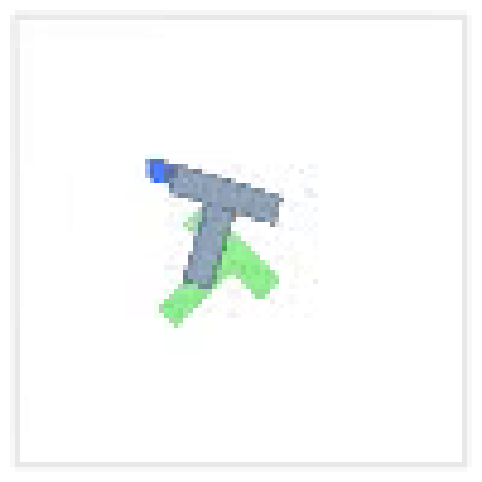

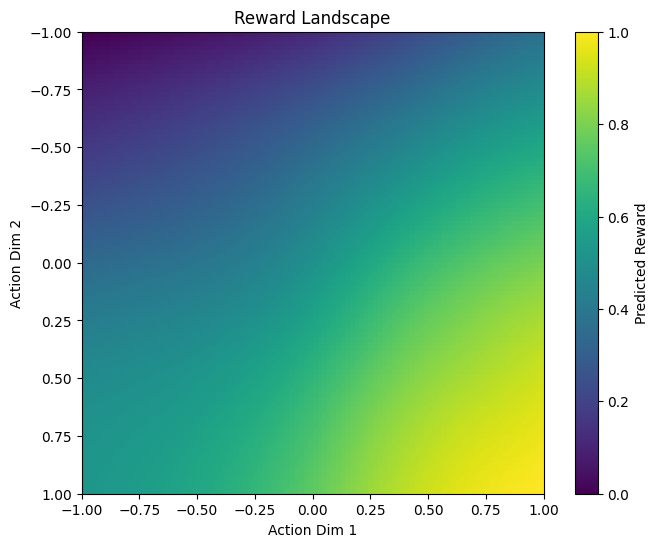

In [107]:
def generate_reward_map(policy, obs, state, resolution=100):
    """Generate a reward landscape by scanning over possible actions.
    Args:
        policy: The trained CVAE policy
        obs: Image observation tensor of shape (1,3,96,96) 
        state: State tensor of shape (1,2)
        resolution: Number of points to sample in each action dimension
        
    Returns:
        actions: (resolution*resolution, 14) tensor of sampled actions
        rewards: (resolution*resolution,) tensor of predicted rewards
    """
    # Encode state and observation
    with torch.no_grad():
        zs = policy.state_encoder(obs, state)
        
        # Create action grid from (-1,-1) to (1,1)
        x = torch.linspace(-1, 1, resolution)
        y = torch.linspace(1, -1, resolution)  # Reversed y range
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Create full action tensor with zeros
        actions = torch.zeros((resolution*resolution, 14), device=obs.device)
        # Fill first two dimensions with grid values
        for i in range(5):
            actions[:, 2*i] = xx.flatten()
            actions[:, 2*i+1] = yy.flatten()

        
        # Encode each action
        za_list = []
        rewards = []

        # Process in batches to avoid memory issues
        batch_size = 100
        z = torch.randn(1,64).repeat(batch_size,1).cuda()
        for i in range(0, len(actions), batch_size):
            action_batch = actions[i:i+batch_size]
            
            # Encode action
            za = policy.action_encoder(action_batch)
            
            # # Get latent from encoder
            # z_mu, z_logvar = policy.fusing_encoder(
            #     zs.repeat(len(action_batch),1), 
            #     za
            # )

            # z = policy.reparameterize(z_mu,z_logvar)
            
            
            # Decode reward
            reward = policy.reward_decoder(
                zs.repeat(len(action_batch),1),
                za, 
                z
            )
            rewards.append(reward)
            
        rewards = torch.cat(rewards, dim=0)
        
        rewards = rewards.squeeze(-1).cpu().numpy()

        # Normalize rewards to [0,1] range
        rewards = (rewards - rewards.min()) / (rewards.max() - rewards.min())

        action = actions.cpu().numpy()

        # Reshape rewards for plotting
        reward_grid = rewards.reshape(100,100)

        # Plot with matplotlib
        import matplotlib.pyplot as plt
        
        # Plot and save observation image
        dir = "./output/img"
        plt.figure(figsize=(8,6))
        obs_img = obs.squeeze().permute(1,2,0).cpu().numpy()
        plt.imshow(obs_img)
        plt.axis('off')
        plt.savefig(f'{dir}/observation.png')
        plt.show()
        
        # Plot and save reward map
        plt.figure(figsize=(8,6))
        plt.imshow(reward_grid, extent=[-1,1,1,-1], origin='lower')
        plt.colorbar(label='Predicted Reward')
        plt.xlabel('Action Dim 1')
        plt.ylabel('Action Dim 2') 
        plt.title('Reward Landscape')
        plt.savefig(f'{dir}/reward_map.png')
        plt.show()

        return action, rewards

# Example usage:
obs = batch['observation.image'][0].cuda()
state = batch['observation.state'][0].cuda()/512 * 2 - 1
action, rewards = generate_reward_map(policy_, obs, state)


In [94]:
config_dict = {
        "horizon": 7,
        "action_dim": 2,
        "state_dim": 512*3*3 + 2,
        "batch_size": 16,
        "latent_dim_state": 50,
        "latent_dim_action": 2,  # Same as action_dim
        "posterior_dim": 64,
        "beta": 1.0,
        "training_steps": 3000,
        "learning_rate": 3e-4,
        "max_iterations": 50,
        "step_size": 1e-4,
        "damping": 1e-3,
        "min_std": 1e-4,
        "discount": 0.9,
        "log_freq": 1,
        "eval_freq": 40,
        "output_directory": "./output",
        "device": "cuda:0",
        "gradient_accumulation_steps": 4,  # Added gradient accumulation config
        "eval_split": 0.05
    }

config = Config(config_dict)
policy_ = CVAEWithTrajectoryOptimization(config)

In [97]:
checkpoint = torch.load("./output/best_model_/model.pt")

/tmp/ipykernel_2867674/804462426.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./output/best_model_/model.pt")


In [100]:
policy_.state_encoder.load_state_dict(checkpoint['state_encoder'])
policy_.action_encoder.load_state_dict(checkpoint['action_encoder'])
policy_.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
policy_.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
policy_.action_decoder.load_state_dict(checkpoint['action_decoder'])
policy_.reward_decoder.load_state_dict(checkpoint['reward_decoder'])

<All keys matched successfully>

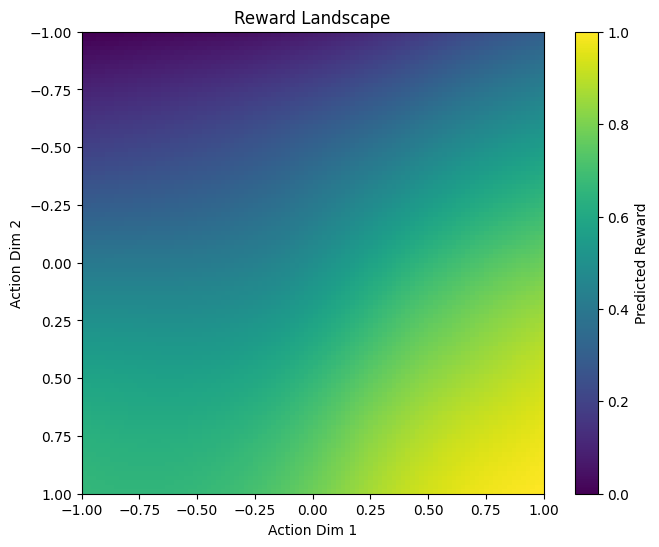

In [101]:
action, rewards = generate_reward_map(policy_, obs, state)


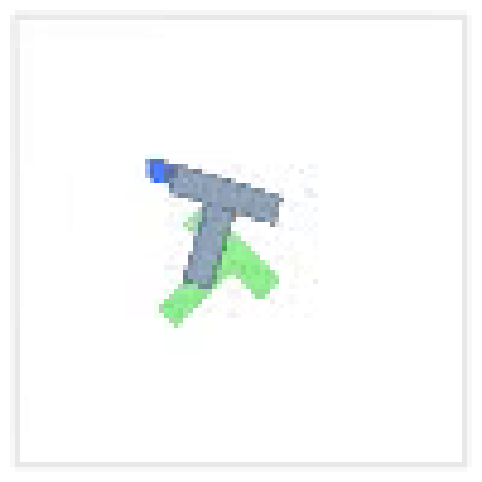

In [78]:
plt.figure(figsize=(8,6))
plt.imshow(obs.squeeze().permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()

In [ ]:
from pathlib import Path
output_directory = Path("outputs/eval/example_pusht_diffusion")
output_directory.mkdir(parents=True, exist_ok=True)

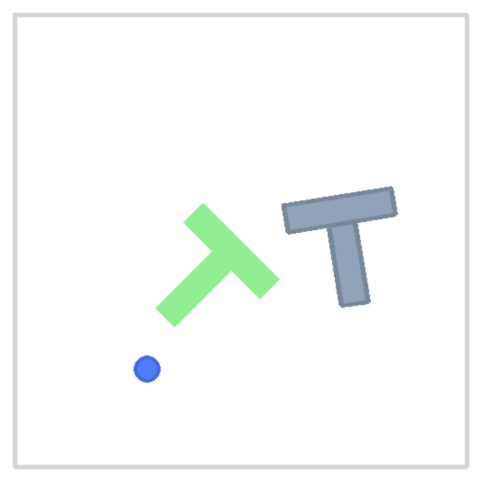

/tmp/ipykernel_2867674/2973899258.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs[:,0,...], dtype=torch.float32, device=self.device) # [bs, 3, 96, 96]
/tmp/ipykernel_2867674/2973899258.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state[:,0,...], dtype=torch.float32, device=self.device)# [bs, 2]
/tmp/ipykernel_2867674/2973899258.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float32, device=self.device) # [bs, horizon * 2 * 2]


torch.Size([1, 7, 14])
tensor([[-0.0210,  0.6781],
        [ 0.0831,  0.6386],
        [ 0.0303,  0.5969],
        [ 0.3329, -3.0507],
        [ 0.2760, -4.1380]])
[250.62833 429.60303]
step=0 reward=0.0 terminated=False


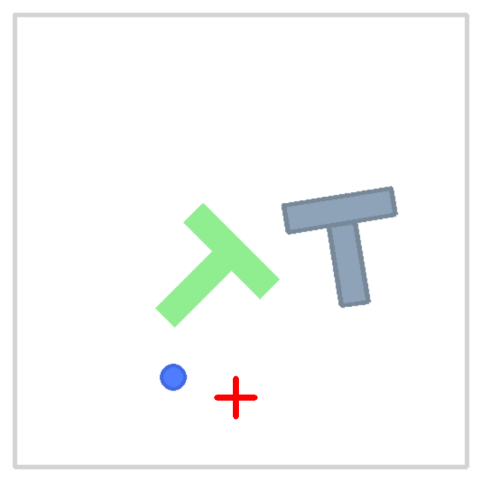

[277.2795  419.49063]
step=1 reward=0.0 terminated=False


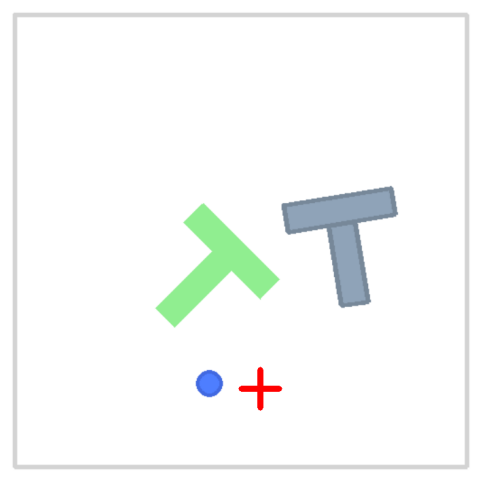

[263.75845 408.79675]
step=2 reward=0.0 terminated=False


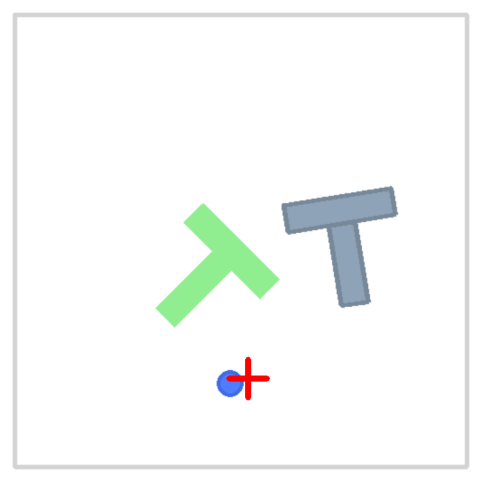

[ 341.21326 -524.9917 ]
step=3 reward=0.0 terminated=False


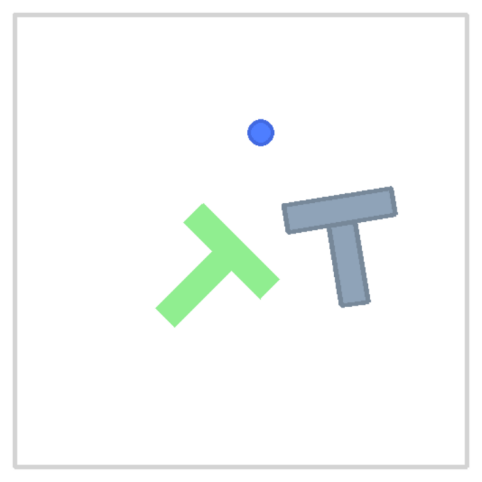

[ 326.65717 -803.32227]
step=4 reward=0.0 terminated=False


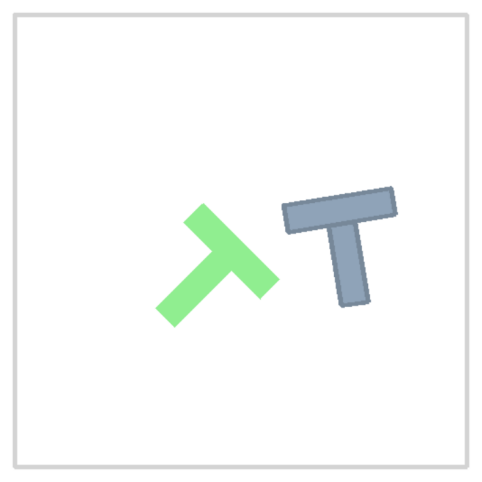

torch.Size([1, 7, 14])
tensor([[ 0.4235, -0.2883],
        [ 0.4230, -0.2817],
        [ 0.4506, -0.2822],
        [ 0.3613, -2.5396],
        [ 0.3538, -3.5032]])
[364.4097  182.18524]
step=5 reward=0.0 terminated=False


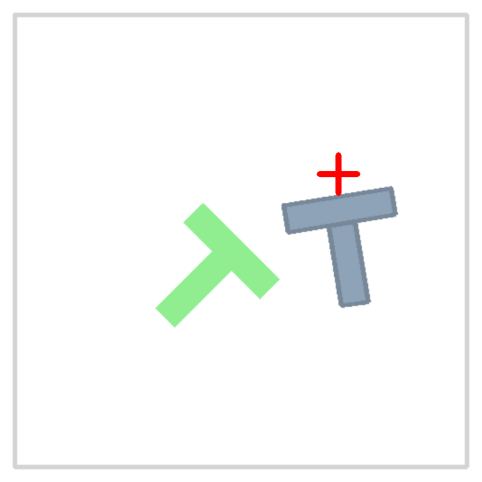

[364.2774  183.89343]
step=6 reward=0.0 terminated=False


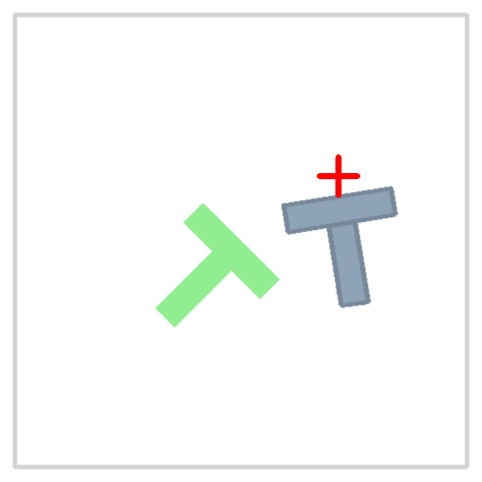

[371.36523 183.76825]
step=7 reward=0.0 terminated=False


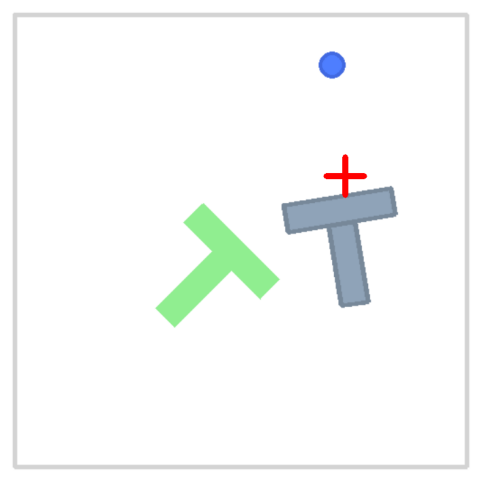

[ 348.49686 -394.13354]
step=8 reward=0.0 terminated=False


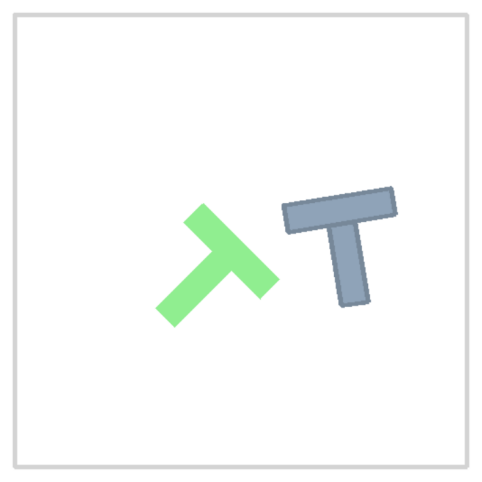

[ 346.57358 -640.8281 ]
step=9 reward=0.0 terminated=False


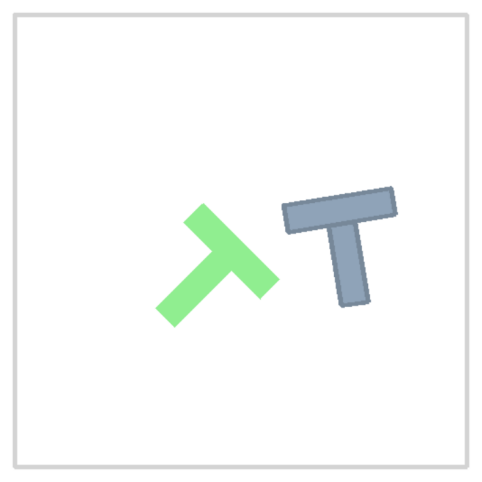

torch.Size([1, 7, 14])
tensor([[ 0.4566, -0.3262],
        [ 0.4427, -0.3244],
        [ 0.4796, -0.3158],
        [ 0.3838, -2.5859],
        [ 0.3867, -3.5482]])
[372.9002  172.48225]
step=10 reward=0.0 terminated=False


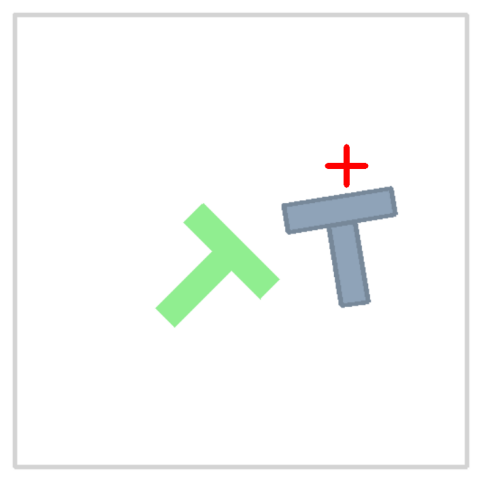

[369.33917 172.94414]
step=11 reward=0.0 terminated=False


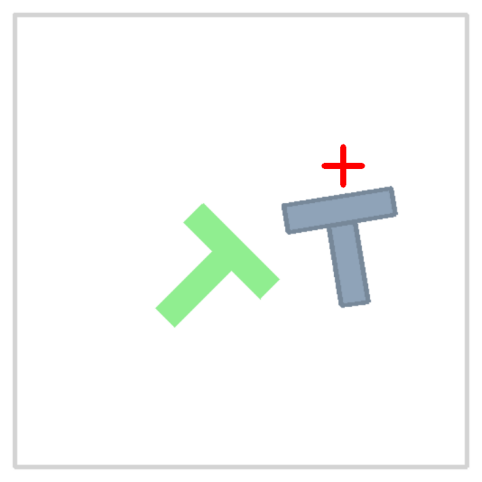

[378.77353 175.14594]
step=12 reward=0.0 terminated=False


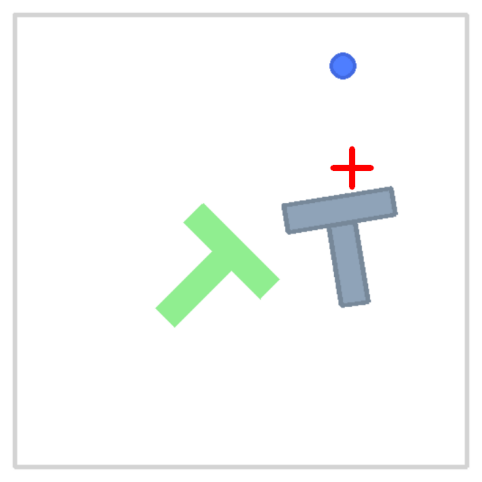

[ 354.25116 -405.99768]
step=13 reward=0.0 terminated=False


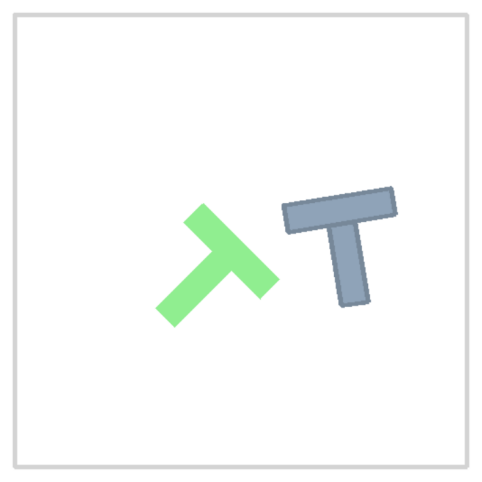

[ 354.98743 -652.33673]
step=14 reward=0.0 terminated=False


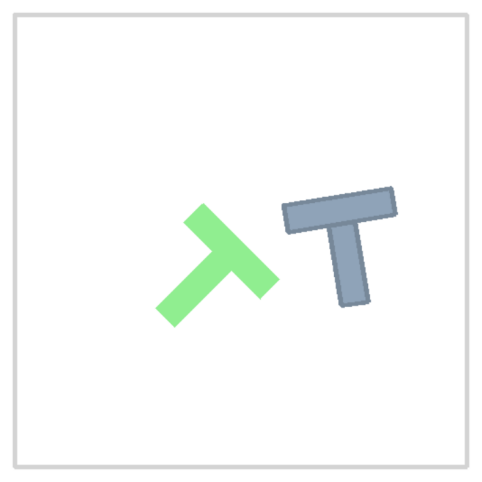

torch.Size([1, 7, 14])
tensor([[ 0.4557, -0.3188],
        [ 0.4423, -0.3145],
        [ 0.4814, -0.3084],
        [ 0.4002, -2.6654],
        [ 0.4105, -3.6484]])
[372.65863 174.3944 ]
step=15 reward=0.0 terminated=False


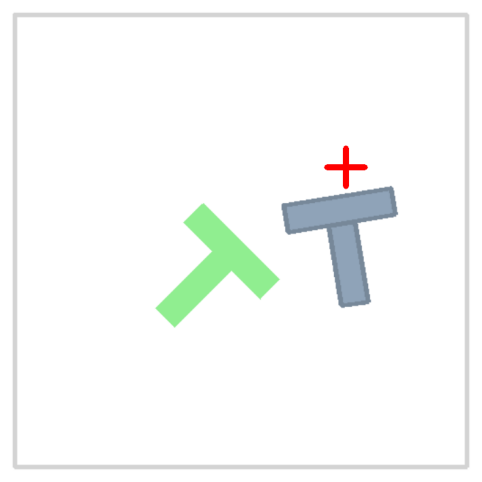

[369.23117 175.49435]
step=16 reward=0.0 terminated=False


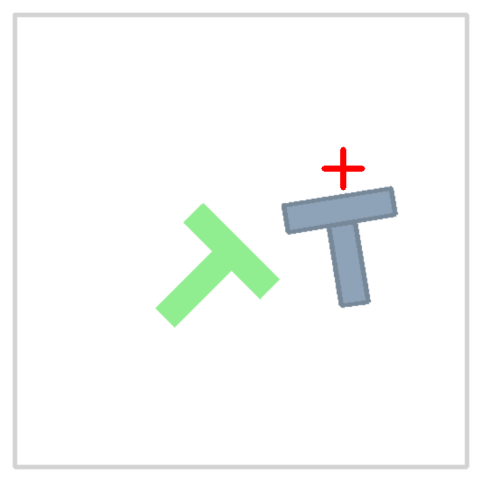

[379.24802 177.04059]
step=17 reward=0.0 terminated=False


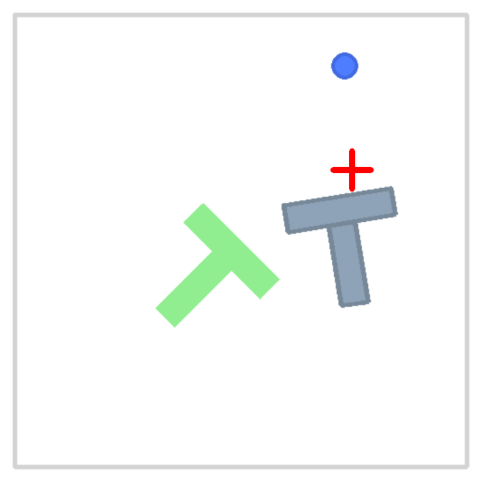

[ 358.44095 -426.34045]
step=18 reward=0.0 terminated=False


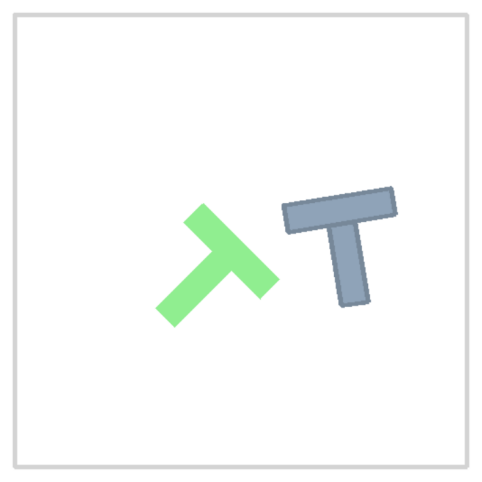

[ 361.08777 -677.98175]
step=19 reward=0.0 terminated=False


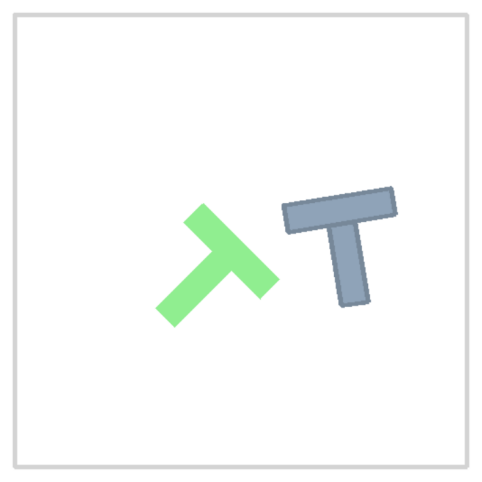

torch.Size([1, 7, 14])
tensor([[ 0.4505, -0.3238],
        [ 0.4347, -0.3155],
        [ 0.4739, -0.3126],
        [ 0.3777, -2.5852],
        [ 0.3865, -3.5394]])
[371.3182 173.1077]
step=20 reward=0.0 terminated=False


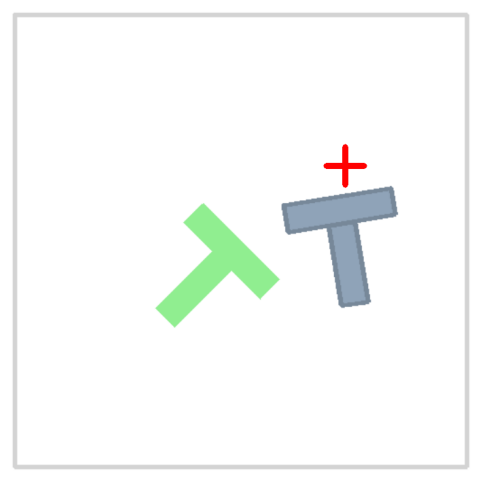

[367.27267 175.2199 ]
step=21 reward=0.0 terminated=False


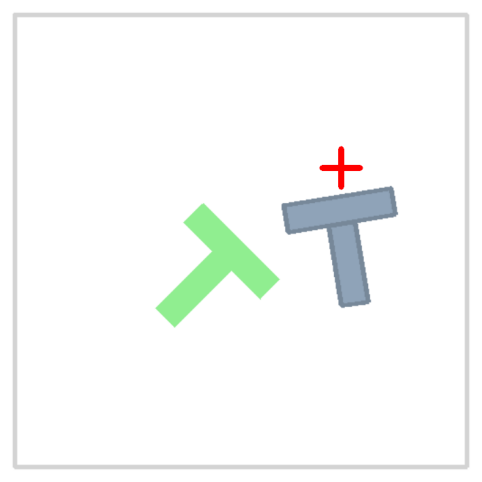

[377.30762 175.98692]
step=22 reward=0.0 terminated=False


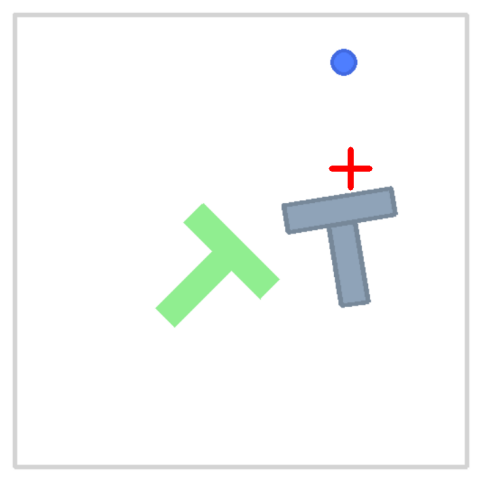

[ 352.6797  -405.81915]
step=23 reward=0.0 terminated=False


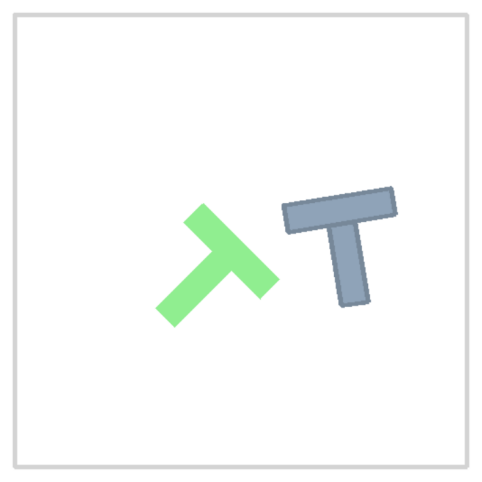

[ 354.94376 -650.08234]
step=24 reward=0.0 terminated=False


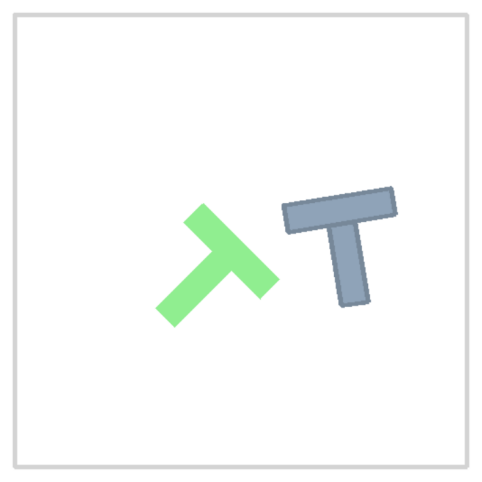

torch.Size([1, 7, 14])
tensor([[ 0.4495, -0.3159],
        [ 0.4359, -0.3199],
        [ 0.4788, -0.3089],
        [ 0.4292, -2.7938],
        [ 0.4370, -3.8010]])
[371.07294 175.1189 ]
step=25 reward=0.0 terminated=False


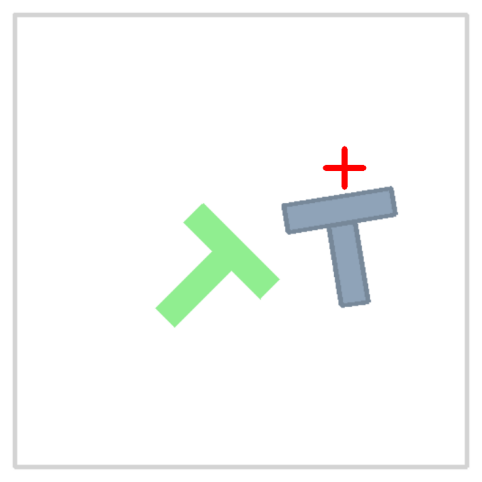

[367.59283 174.11473]
step=26 reward=0.0 terminated=False


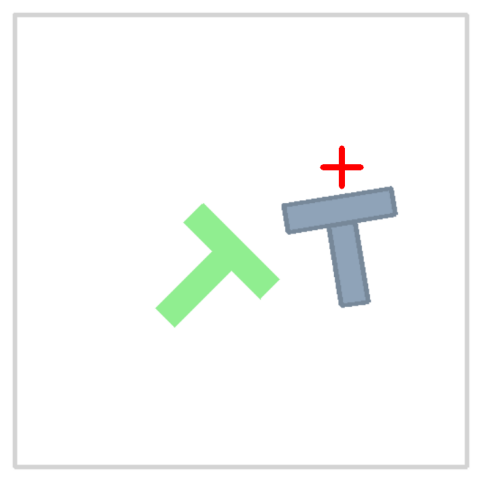

[378.58447 176.92393]
step=27 reward=0.0 terminated=False


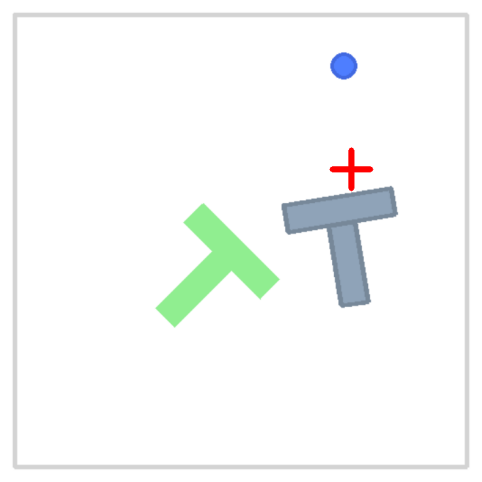

[ 365.8873  -459.21503]
step=28 reward=0.0 terminated=False


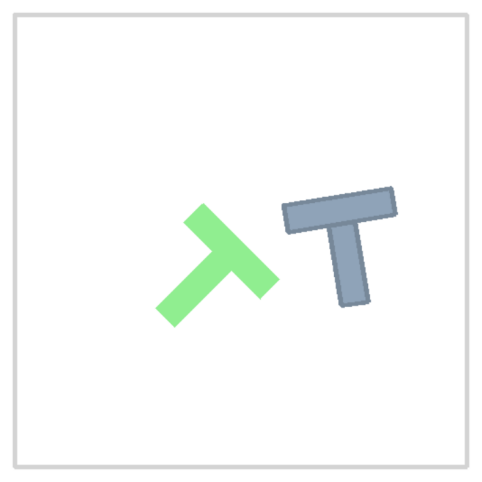

[ 367.86127 -717.04694]
step=29 reward=0.0 terminated=False


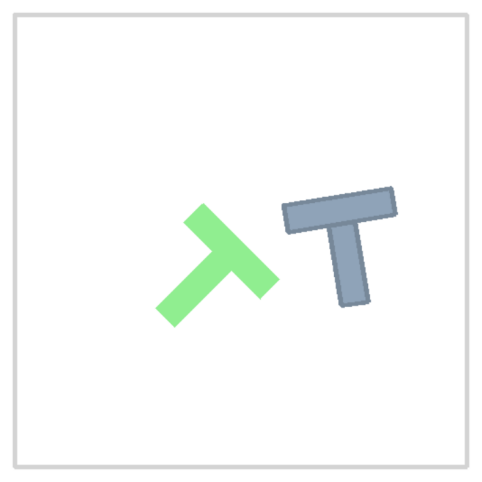

torch.Size([1, 7, 14])
tensor([[ 0.4638, -0.3216],
        [ 0.4540, -0.3248],
        [ 0.4977, -0.3133],
        [ 0.4327, -2.7965],
        [ 0.4422, -3.8106]])
[374.74408 173.66895]
step=30 reward=0.0 terminated=False


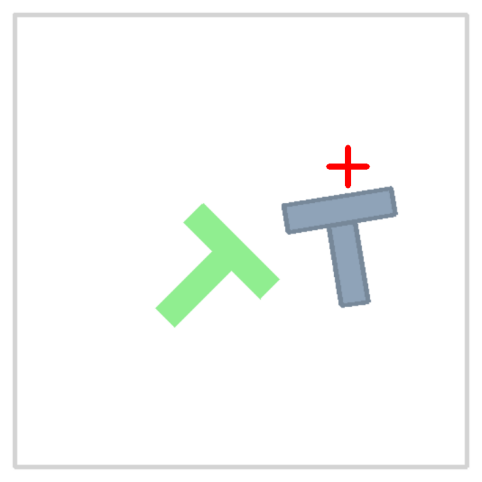

[372.22217 172.84872]
step=31 reward=0.0 terminated=False


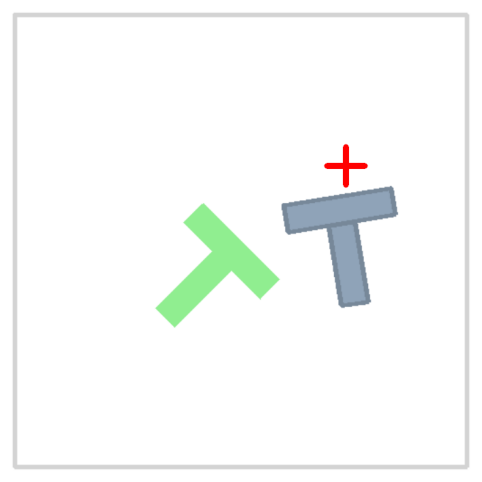

[383.40573 175.79156]
step=32 reward=0.0 terminated=False


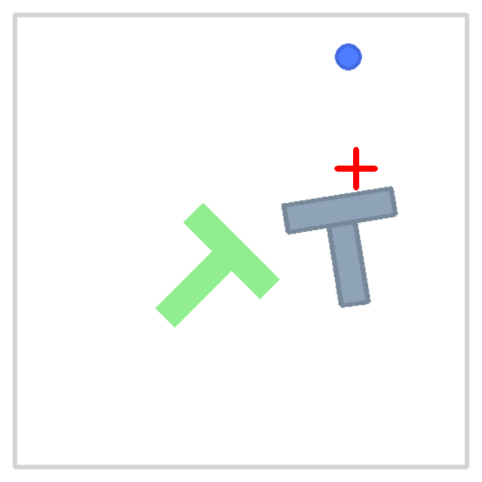

[ 366.77258 -459.90118]
step=33 reward=0.0 terminated=False


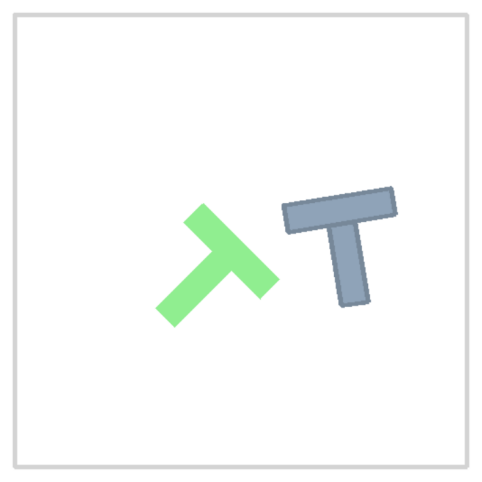

[ 369.20712 -719.5176 ]
step=34 reward=0.0 terminated=False


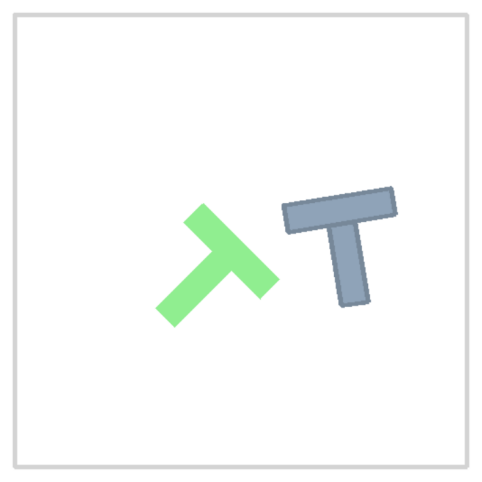

torch.Size([1, 7, 14])
tensor([[ 0.4961, -0.3157],
        [ 0.4904, -0.3223],
        [ 0.5322, -0.3064],
        [ 0.4269, -2.7791],
        [ 0.4258, -3.8240]])
[383.0111 175.1706]
step=35 reward=0.0 terminated=False


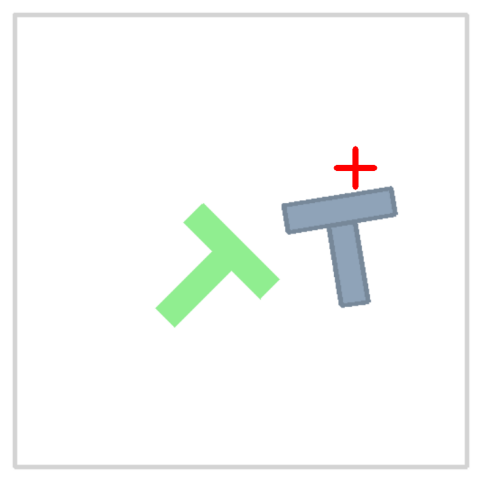

[381.55145 173.48647]
step=36 reward=0.0 terminated=False


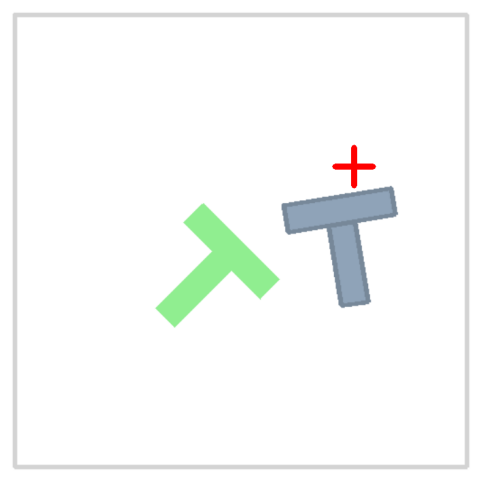

[392.23615 177.54903]
step=37 reward=0.0 terminated=False


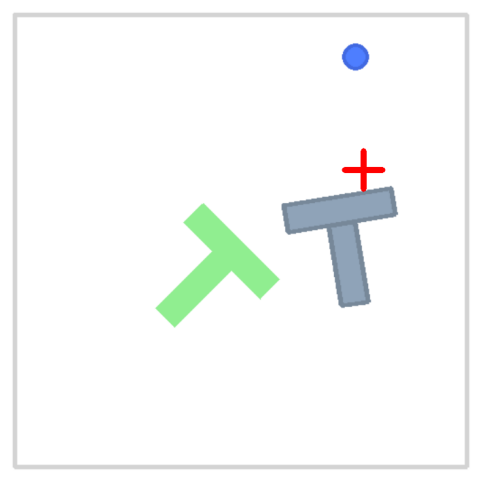

[ 365.29904 -455.458  ]
step=38 reward=0.0 terminated=False


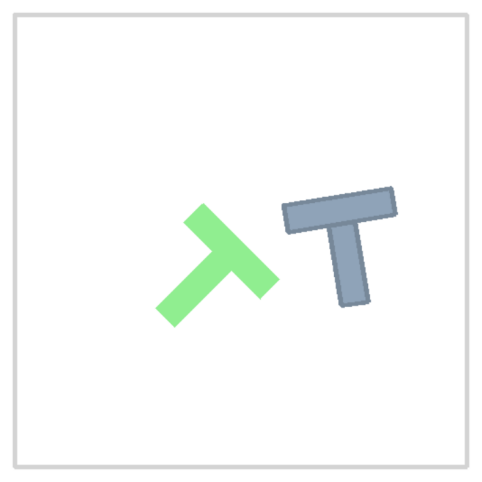

[ 365.01044 -722.9426 ]
step=39 reward=0.0 terminated=False


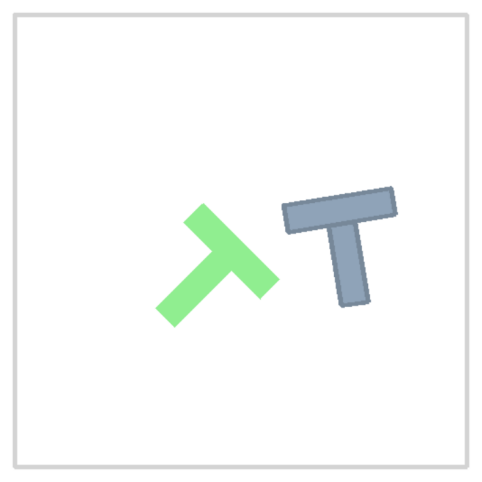

torch.Size([1, 7, 14])


KeyboardInterrupt: 

In [112]:
import imageio
import numpy
import gym_pusht  # noqa: F401
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

env = gym.make(
    "gym_pusht/PushT-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
    render_mode="rgb_array"
)

cfg = config

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []
numpy_observation, info = env.reset(seed=42)

# Initialize action queue
action_queue = deque(maxlen=7)

# Render frame of the initial state
img = env.render()
frames.append(img)

# Display initial frame
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

step = 0
done = False
while not done:
    # Generate new actions when queue is empty
    if len(action_queue) == 0:
        # Prepare observation for the policy running in Pytorch
        state = torch.from_numpy(numpy_observation["agent_pos"])
        image = torch.from_numpy(numpy_observation["pixels"])

        # Convert to float32 with image from channel first in [0,255]
        # to channel last in [0,1]
        state = state.to(torch.float32)
        image = image.to(torch.float32) / 255
        image = image.permute(2, 0, 1)

        # Send data tensors from CPU to GPU
        state = state.to(device, non_blocking=True)
        image = image.to(device, non_blocking=True)
        action = torch.randn(1,28).cuda()

        # Add extra (empty) batch dimension, required to forward the policy
        state = state.unsqueeze(0).unsqueeze(0)/512 * 2 - 1
        obs = image.unsqueeze(0).unsqueeze(0)

        # Predict the next actions with respect to the current observation
        with torch.no_grad():
            output_dict = policy.plan_with_theseus_update(obs, state, action, 7, cfg.discount, cfg, eval_mode=True)

        print(output_dict['best_actions'].shape)
        
        # Get first 3 actions and add to queue
        actions = output_dict['best_actions'][0][0].reshape(-1, 2)[:5]
        print(actions)
        for act in actions:
            numpy_act = (act.numpy() + 1)/2 * 512
            action_queue.append(numpy_act)

    # Get next action from queue
    numpy_action = action_queue.popleft()

    # Step through the environment and receive a new observation
    print(numpy_action)
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    img = env.render()
    frames.append(img)
    
    # Display frame
    # clear_output(wait=True)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

# Encode all frames into a mp4 video.
video_path = output_directory / "rollout.mp4"
imageio.mimsave(str(video_path), numpy.stack(frames), fps=fps)

print(f"Video of the evaluation is available in '{video_path}'.")